In [3]:
import handle_data
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

In [166]:
variable_to_plot = "TotalExpenditure"

In [167]:
def remove_faulty(data: dict, variable, k, groups):
    """
    This function will print the column name and the respective value in the exact same row as the
    instructive PowerPoint listed, which can be used to cross validate data changes

    :param data: dataframe to compare, variable: the output parameter that we are deleting data from, k: parameter of how much data to delete (1.5), group: list of data-types (ADA etc.)
    :return: Dataset without outliers
    """

    full_data = pd.concat([data["Output"], data["Input"]], axis=1)
    print("Input data shape: ", full_data.shape)
    for group in groups:
        part_data = full_data[(full_data['IdentifierType'] == group)]
        
        scenarios = set(part_data['IdentifierScenario'])
        for scenario in scenarios:
            df = full_data[(full_data['IdentifierScenario'] == scenario) & (full_data['IdentifierType'] == group)]
            list = df[variable]
            use = list.sort_values(ascending = True)
            data_amount = len(list)
            data_amount_quart = int(data_amount / 4)

            IQR = use[use.index[3* int(data_amount_quart)]] - use[use.index[int(data_amount_quart)]]

            whisker = k * IQR  # To keep more values put 2*IQR or something else
            acceptable_min = use[use.index[int(data_amount_quart)]] - whisker
            acceptable_max = use[use.index[3* int(data_amount_quart)]] + whisker
            full_data = full_data[~((full_data['IdentifierScenario'] == scenario) & (full_data[variable] >= acceptable_max) & (full_data['IdentifierType'] == group))]
            full_data = full_data[~((full_data['IdentifierScenario'] == scenario) & (full_data[variable] <= acceptable_min) & (full_data['IdentifierType'] == group))]
    
    print("Shape after removing outliers: ", full_data.shape)
    output_data = full_data.iloc[:, :full_data.columns.get_loc("Gui")]
    input_data = full_data.iloc[:, full_data.columns.get_loc("Gui"):]
    
    output = dict()
    output["Input"] = input_data
    output["Output"] = output_data
    return output

In [168]:
def import_data():
    # Import the data
    data = handle_data.csv_to_dataframe("logfiles.csv")
    # Remove outliers from training and val
    data = remove_faulty(data, variable_to_plot, 1.5, ["INI", "ADA", "HO", "VAL"])

    training, val, test = handle_data.split_data(data)

    return training, val, test

In [169]:
training, val, test = import_data()

[DEBUG] Reading logfiles.csv into dataframe
[DEBUG] Finished reading logfiles.csv into dataframe after 0.7011637687683105 seconds
Input data shape:  (127908, 62)
Shape after removing outliers:  (126825, 62)


In [170]:
def get_distance_from_mean(training, test):
    """
    This function will print the column name and the respective value in the exact same row as the
    instructive PowerPoint listed, which can be used to cross validate data changes

    :param data: dataframe to compare, variable: the output parameter that we are deleting data from, k: parameter of how much data to delete (1.5), group: list of data-types (ADA etc.)
    :return: Dataset without outliers
    """
    
    # Training first
    full_data_training = pd.concat([training["Output"], training["Input"]], axis=1)
    data_to_plot_training = pd.DataFrame(columns = ["Value", "DistanceFromMean"])
    
    for part in ["INI", "ADA"]:
        part_data = full_data_training[(full_data_training['IdentifierType'] == part)]
        scenarios = set(part_data['IdentifierScenario'])
        for scenario in scenarios:
            df = full_data_training[(full_data_training['IdentifierScenario'] == scenario) & (full_data_training['IdentifierType'] == part)]
            
            values = df[variable_to_plot]
            mean = values.mean()
            deviation_from_mean = values - mean
            
            combined_df = pd.DataFrame()
            combined_df["Value"] = values
            combined_df["DistanceFromMean"] = deviation_from_mean
            combined_df["Value"] = mean
            data_to_plot_training = pd.concat([combined_df, data_to_plot_training], axis=0)
            
    # Test set
    full_data_test = pd.concat([test["Output"], test["Input"]], axis=1)
    data_to_plot_test = pd.DataFrame(columns = ["Value", "DistanceFromMean"])
    
    part = "VAL"
    part_data = full_data_test[(full_data_test['IdentifierType'] == part)]
    scenarios = set(part_data['IdentifierScenario'])
    for scenario in scenarios:
        df = full_data_test[(full_data_test['IdentifierScenario'] == scenario) & (full_data_test['IdentifierType'] == part)]

        values = df[variable_to_plot]
        mean = values.mean()
        deviation_from_mean = values - mean

        combined_df = pd.DataFrame()
        combined_df["Value"] = values
        combined_df["DistanceFromMean"] = deviation_from_mean
        combined_df["Value"] = mean
        data_to_plot_test = pd.concat([combined_df, data_to_plot_test], axis=0)        
    
    return data_to_plot_training, data_to_plot_test

In [182]:
def plot_data(x_train, x_val, y_train, y_val, xlabel, ylabel):
    fig, axs = plt.subplots(1,3, gridspec_kw={'width_ratios': [3, 1, 1]})
    fig.set_figwidth(15)
    
    colors = ['b', 'yellow']
    # Put all the brothers together
    plt.subplots_adjust(wspace=0.0)
    for c in range(2):
        
        if c == 0:
            axs[0].scatter(x_train, y_train, alpha=0.5, c=(colors[c]), label="Training Data")
            axs[0].set_xlabel(xlabel)
            axs[0].set_ylabel(ylabel)
            axs[0].grid(True)
            plt.grid()

            axs[1].hist(y_train, bins=50, orientation='horizontal', color = colors[c], ec=colors[c])
            axs[1].set_xlabel("Frequency")
            axs[1].grid(True)
            axs[1].set_yticklabels([])

            qqplot = sm.qqplot(y_train, ax = axs[2], markerfacecolor=colors[c], markeredgecolor=colors[c])
            axs[2].set_ylabel("")
            axs[2].yaxis.tick_right()
            axs[2].grid(True)
        else:
            axs[0].scatter(x_test, y_test, alpha=0.5, c=(colors[c]), label="Test data")
            axs[0].set_xlabel(xlabel)
            axs[0].set_ylabel(ylabel)
            axs[0].grid(True)
            plt.grid()
            axs[0].legend(loc='upper right')

            axs[1].hist(y_test, bins=50, orientation='horizontal', color = colors[c], ec=colors[c])
            axs[1].set_xlabel("Frequency")
            axs[1].grid(True)
            axs[1].set_yticklabels([])

            qqplot = sm.qqplot(y_test, ax = axs[2], markerfacecolor=colors[c], markeredgecolor=colors[c])
            axs[2].set_ylabel("")
            axs[2].yaxis.tick_right()
            axs[2].grid(True)
            
        c += 1
    

In [183]:
training_plot, test_plot = get_distance_from_mean(training, test)
x_train = training_plot["Value"]
y_train = training_plot["DistanceFromMean"]
x_test = test_plot["Value"]
y_test = test_plot["DistanceFromMean"]

plotting = [training_plot, test_plot]

print("Train: ", abs(y_train).mean())
print("Val: ", abs(y_test).mean())

print(y_test.std())

Train:  90.72157219653154
Val:  94.7226296412449
118.22557031134009


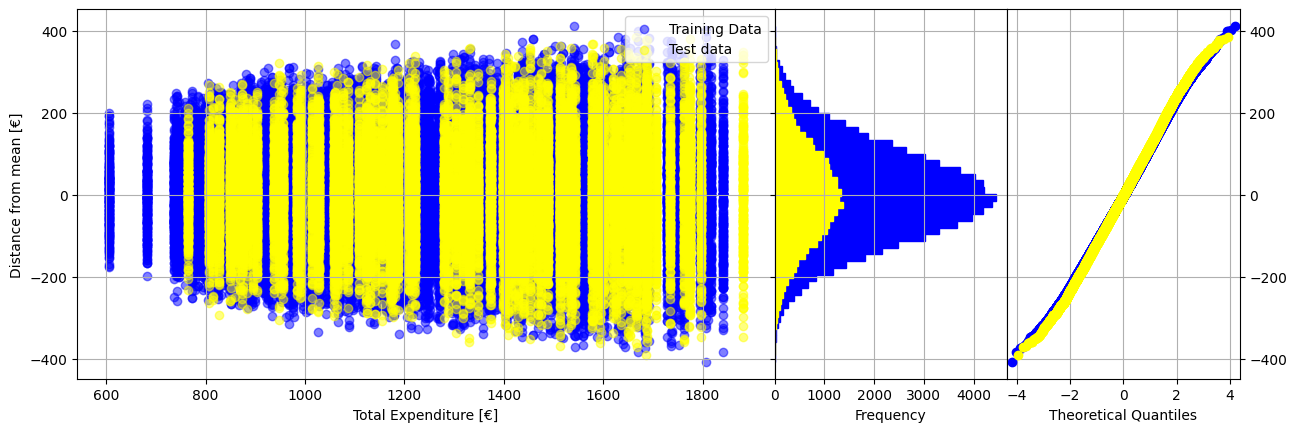

In [184]:
xlabel = "Total Expenditure [€]"
ylabel = "Distance from mean [€]"

plot_data(x_train, x_test, y_train, y_test, xlabel, ylabel)